# <font color=black> Create individual mask from iCAP analysis </font>
<hr style="border:1px solid black">

**The goal of this analysis is to create individual binary mask for seed2voxel analysis.**

**Step1:**
- Order individual icaps
- plot
- save a 3D file with frostell level name

**Step2:**
- Threshold and binarize the icap


In [30]:
import glob, os
OutputDir='/cerebro/cerebro1/dataset/stratals/derivatives/preprocessing/' 
OutputDir='/cerebro/cerebro1/dataset/bmpd/derivatives/spinalcord_processing/' 
#"A028"
for subject_name in ["P030","P099"]:#,"A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]:
    template_out= OutputDir + 'sub-' + subject_name + '/anat/T1w_sc_coreg_new_CL/' + '/template_in_T1w'
    
    Files_func_mean=glob.glob(OutputDir +  'sub-' + subject_name + '/func/3_MOCO/spinalcord/' + "*stc_sc_moco_mean.nii.gz")[0]
    PAM50_t2=template_out + '/template/PAM50_t2.nii.gz'
    Files_func_seg=OutputDir +  '/sub-' + subject_name + '/func/4_Segmentation/spinalcord/' + Files_func_mean.split('/')[-1].split('.')[0] + '_seg.nii.gz'
        
    PAM50_csfwmgm=template_out + '/template/PAM50_csfwmgm.nii.gz'
    params_func_to_T1w='step=1,type=seg,algo=slicereg,metric=MeanSquares:step=2,type=seg,algo=affine,metric=MeanSquares,gradStep=0.2:step=3,type=im,algo=syn,metric=CC,iter=5,shrink=2'
    Func_mean_in_T1w= OutputDir +  'sub-' + subject_name + '/func/5_Coregistration/spinalcord/' + Files_func_mean.split('/')[-1].split('.')[0] + '_coreg_in_T1w.nii.gz'
    warp_from_func_to_T1w=OutputDir +  'sub-' + subject_name + '/func/5_Coregistration/spinalcord/' + 'sub-'  + subject_name + '_from-func_to-T1w_mode-image_xfm.nii.gz'

    string="sct_register_multimodal -i " + Files_func_mean + " -d " + PAM50_t2 +" -iseg " + Files_func_seg +" -dseg "+ PAM50_csfwmgm + " -param "+params_func_to_T1w+" -o "+Func_mean_in_T1w+" -owarp "+   warp_from_func_to_T1w+" -x spline"
    #os.system(string)
    input2=OutputDir +  'sub-' + subject_name + '/func/5_Coregistration/spinalcord/warp_PAM50_t22' + Files_func_mean.split('/')[-1]
    output2=OutputDir +  'sub-' + subject_name + '/func/5_Coregistration/spinalcord/warp_T1w_2' + Files_func_mean.split('/')[-1]
    #os.rename(input2,output2)
    
    #Concatenate warp from func_to_T1w and from T1w_to_PAM50
    warp_from_T1w_to_PAM50= OutputDir +  'sub-' + subject_name + '/anat/T1w_sc_coreg_new_CL/'+ 'sub-'  + subject_name + '_from-T1w_to-PAM50_mode-image_xfm.nii.gz'
 
    warp_from_func_to_T1w_to_PAM50=OutputDir +  'sub-' + subject_name + '/func/5_Coregistration/spinalcord/' + 'sub-'  + subject_name + '_from-func_to_T1w_to_PAM50_mode-image_xfm.nii.gz'
    PAM50_T2='/cerebro/cerebro1/dataset/bmpd/derivatives/Func_analyses/Templates/PAM50/template/PAM50_t2_C1T2.nii.gz'
    
    Func_mean_in_PAM50 = OutputDir +  'sub-' + subject_name + '/func/5_Coregistration/spinalcord/' + Files_func_mean.split('/')[-1].split('.')[0] + '_coreg_in_PAM50.nii.gz'
    string='sct_concat_transfo -d ' +PAM50_T2 +' -w '+warp_from_func_to_T1w+ ' '+warp_from_T1w_to_PAM50 +' -o ' +warp_from_func_to_T1w_to_PAM50
    os.system(string)
    
    
    #os.system('find /tmp /var/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
    #os.system('find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;')
    
    string2='sct_apply_transfo -i ' +Files_func_mean +' -d ' + PAM50_T2 +' -o '+ Func_mean_in_PAM50+' -w '+ warp_from_func_to_T1w_to_PAM50 + ' -r 0 -v 2'
    os.system(string2)

In [1]:
import sys,json
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import seaborn as sns
import os 
from matplotlib import pyplot as plt

#sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')
sys.path.append('/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/code/')

from plotting import Plotting
from spine_only_analysis import SpineOnlyAnalysis
from compute_similarity import compute_similarity
%matplotlib inline
%load_ext autoreload
%autoreload 2

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/bmpd_python/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()


<hr style="border:1px solid black">

# Initialization
### Load configuration file 

In [2]:
# Load the config files with all informations (i.e., all datasets, methods, etc.)
with open('../../config/config_spine_mask.json') as config_file:
    config = json.load(config_file)
    
#with open('../config/config_spine_only_CL.json') as config_file:
#    config = json.load(config_file)
    

In [3]:
config['list_subjects']

['P099', 'P030', 'A006', 'A007', 'A008', 'A009', 'A038', 'A025']

<hr style="border:1px solid black">

# Plot individual components

Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
When using the maximum intensity projection, centering method is set to 'middle'
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
When using the maximum intensity projection, centering method is set to 'middle'
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
When using the maximum intensity projection, centering method is set to 'middle'
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Right)
When using the maximum intensity projection, centering method is set to 'middle'
Sorting method: rostrocaudal (center-of-mass biggest cluster)
The plotting will be displayed in neurological orientation (Left > Rig

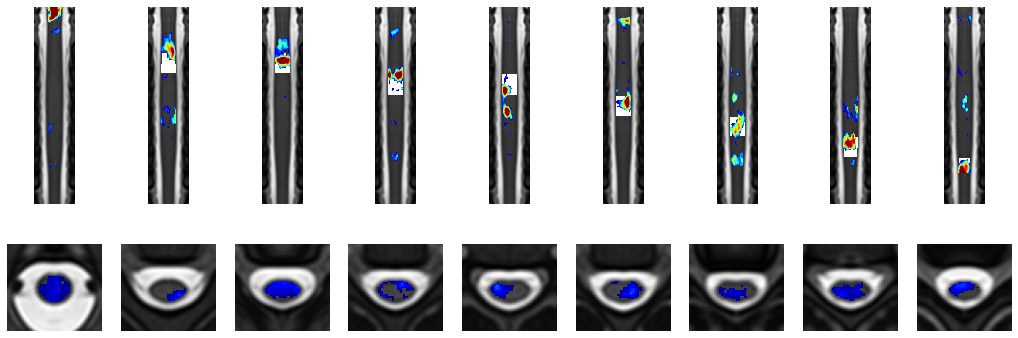

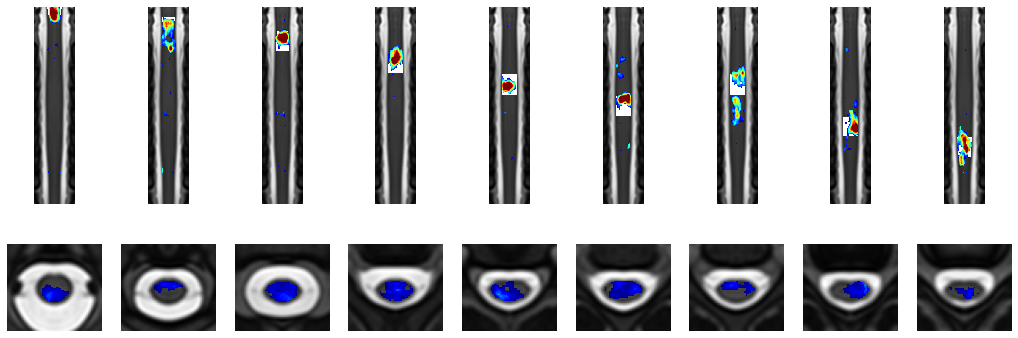

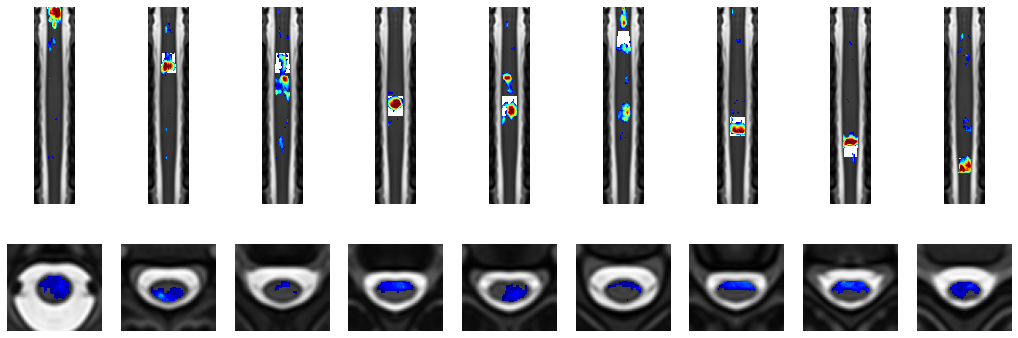

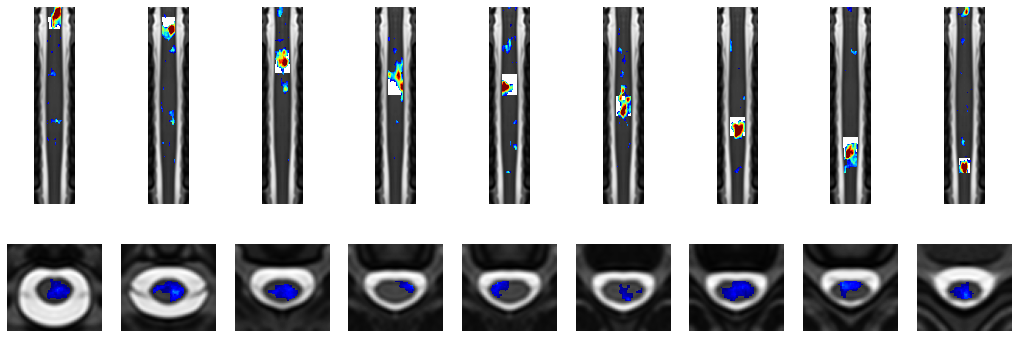

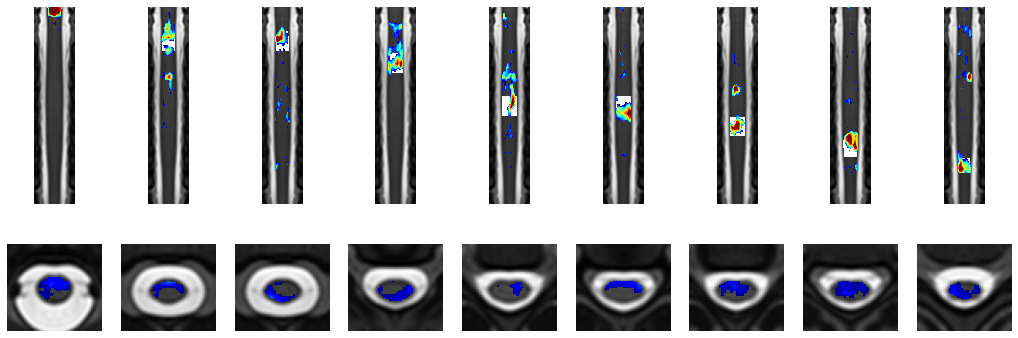

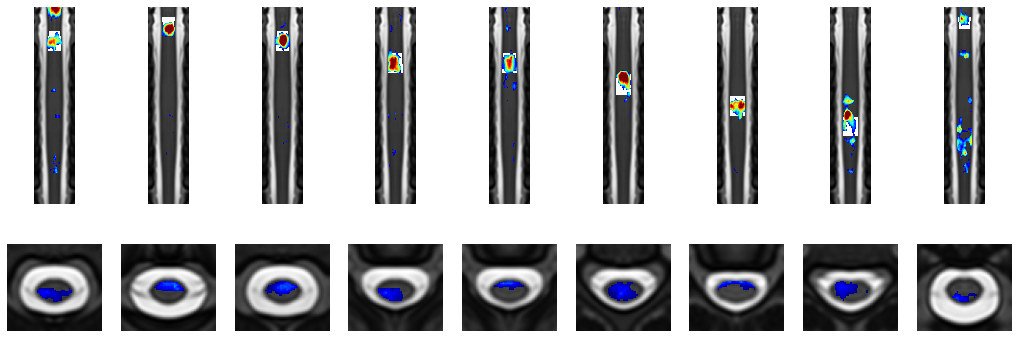

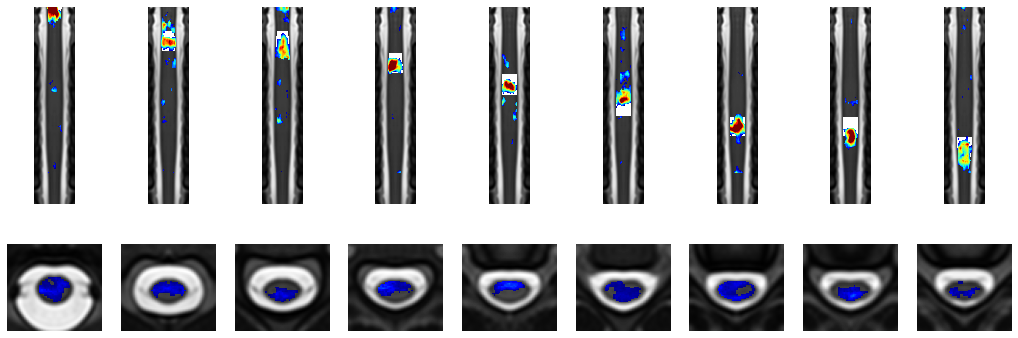

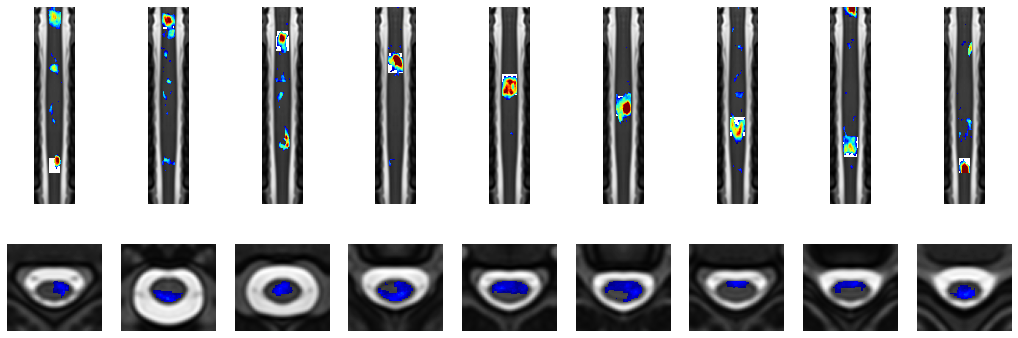

In [3]:
# Define parameters for the dataset to visualize
# Note: it is possible to look at a single dataset (in that case, just define params1), or to compare two (in that case, also add params2)
# Each param dict has 3 values: k, dataset and analysis

for sub in config['list_subjects']:
    #params_qual_1 = {'k':9, 'dataset':'mtl', 'analysis':'icap','lthresh':1.6}   
    params_qual_1 = {'k':9, 'dataset':'young', 'analysis':'icap', 'subject':sub,'lthresh':1.6}   

    plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
    #plotting = Plotting(config,'spinalcord',params1=params_qual_1,sorting_method='rostrocaudal_CoM')
    plotting.sc_plot(show_spinal_levels=True, k_per_line=9,  lthresh=1.6, uthresh=35,plot_mip=True,colormap_one='jet',  centering_method='max', save_results=False) # plot_mip=True,colormap_one='jet',

<hr style="border:1px solid black">

# Create individual masks

In [15]:
for sub in config['list_subjects']:
    input_4D_file=glob.glob(config["main_dir"] + config["data"]["young"]["icap"]["spinalcord"]["dir"] + "/K_9/comp_indiv/sub-" + sub + "_iCAPs_z.nii")[0]
    tag_3D="sub-" + sub + "_iCAPs_"
    string="fslsplit " + input_4D_file + " " + config["main_dir"] + config["data"]["young"]["icap"]["spinalcord"]["dir"] + "/K_9/comp_indiv/3D/" + tag_3D +" -t"
    print(string)
    os.system(string) # transform 4D to 3D file



fslsplit /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_brsc_project/young/spinalcord//K_9/comp_indiv/sub-P099_iCAPs_z.nii /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_brsc_project/young/spinalcord//K_9/comp_indiv/3D/sub-P099_iCAPs_ -t
fslsplit /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_brsc_project/young/spinalcord//K_9/comp_indiv/sub-P030_iCAPs_z.nii /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_brsc_project/young/spinalcord//K_9/comp_indiv/3D/sub-P030_iCAPs_ -t
fslsplit /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_brsc_project/young/spinalcord//K_9/comp_indiv/sub-A006_iCAPs_z.nii /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/results_brsc_project/young/spinalcord//K_9/comp_indiv/3D/sub-A006_iCAPs_ -t
fslsplit /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project//iCAP/

In [17]:
for sub in config['list_subjects']:
    input_file=config["main_dir"] + "hc_project_analyses/mask/spinalcord/Indiv/sub-" + sub + "_iCAPs_C7.nii.gz" 
    output_file=config["main_dir"] + "hc_project_analyses/mask/spinalcord/Indiv/sub-" + sub + "_iCAPs_indivC7_bin.nii.gz" 
    
    if not os.path.exists(output_file):
        string="fslmaths " + input_file + " -thr 2.2 -bin " + output_file
        print(string)
        os.system(string) # transform 4D to 3D file



fslmaths /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask/spinalcord/Indiv/sub-P099_iCAPs_C7.nii.gz -thr 2.2 -bin /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask/spinalcord/Indiv/sub-P099_iCAPs_indivC7_bin.nii.gz
fslmaths /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask/spinalcord/Indiv/sub-P030_iCAPs_C7.nii.gz -thr 2.2 -bin /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask/spinalcord/Indiv/sub-P030_iCAPs_indivC7_bin.nii.gz
fslmaths /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask/spinalcord/Indiv/sub-A006_iCAPs_C7.nii.gz -thr 2.2 -bin /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask/spinalcord/Indiv/sub-A006_iCAPs_indivC7_bin.nii.gz
fslmaths /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/hc_project_analyses/mask

134

In [28]:
input_file=[]
for sub in config['list_subjects']:
    input_file.append(config["main_dir"] + "seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-" + sub + ".nii.gz")
    output_file=config["main_dir"] + "seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_8subjects_seed_C7_s_4D.nii.gz"
    
string="fslmerge -t " + str(input_file).split("[")[-1].split("]")[0] + " " + output_file
print(string)
os.system(string) # transform 4D to 3D file

fslmerge -t '/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-P099.nii.gz', '/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-P030.nii.gz', '/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-A006.nii.gz', '/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-A007.nii.gz', '/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-A008.nii.gz', '/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_sub-A009.n

134

In [31]:
output_file2=config["main_dir"] + "seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_8subjects_seed_C7_s_mean.nii.gz"
    
string="fslmaths " + output_file + " -Tmean " + output_file2
print(string)
os.system(string)

fslmaths /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_8subjects_seed_C7_s_4D.nii.gz -Tmean /cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/seed_to_voxels/spring_2023/1_first_level/spinalcord_C7/MNI_GM_3mm_fc_maps/MI/mi_8subjects_seed_C7_s_mean.nii.gz


0